Thinkful Bootcamp Course

Author: Ian Heaton

Email: iheaton@gmail.com

Mentor: Nemanja Radojkovic

Date: 2017/06/03


In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb

from time import time
from IPython.display import display
from sklearn.neural_network import MLPClassifier
from sklearn import metrics
from sklearn.grid_search import GridSearchCV

%matplotlib inline

sb.set_style('darkgrid')
my_dpi = 96

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

# Mordern Art Classification with Multi-Layer Perceptron


## Question:
Can art work features such as title, artist and date of art work be used to correctly classify which department the artwork belongs to? 

### Data:
For this Drill we'll use The Museum of Modern Art in New York's [public dataset](https://media.githubusercontent.com/media/MuseumofModernArt/collection/master/Artworks.csv) on their collection.


### Context:

### Content:


In [16]:
# Read CSV containing text data
data_url = 'https://media.githubusercontent.com/media/MuseumofModernArt/collection/master/Artworks.csv'
artworks = pd.read_csv(data_url)
print("\nNumber of Observations : %d\n" % (artworks.shape[0]))
print("Number of Features : %d\n" % (artworks.shape[1]))


Number of Observations : 130918

Number of Features : 29



## Preprocessing and exploratory data analysis
We'll also do a bit of data processing and cleaning, selecting columns of interest and converting URL's to booleans indicating whether they are present.

In [17]:
# Select Columns.
artworks = artworks[['Artist', 'Nationality', 'Gender', 'Date', 'Department',
                    'DateAcquired', 'URL', 'ThumbnailURL', 'Height (cm)', 'Width (cm)']]

# Convert URL's to booleans.
artworks['URL'] = artworks['URL'].notnull()
artworks['ThumbnailURL'] = artworks['ThumbnailURL'].notnull()

# Drop films and some other tricky rows.
artworks = artworks[artworks['Department']!='Film']
artworks = artworks[artworks['Department']!='Media and Performance Art']
artworks = artworks[artworks['Department']!='Fluxus Collection']

# Drop missing data.
artworks = artworks.dropna()
artwork.head()

,Title,Artist,ConstituentID,ArtistBio,Nationality,BeginDate,EndDate,Gender,Date,Medium,...,ThumbnailURL,Circumference (cm),Depth (cm),Diameter (cm),Height (cm),Length (cm),Weight (kg),Width (cm),Seat Height (cm),Duration (sec.)
0,"Ferdinandsbrücke Project, Vienna, Austria, Ele...",Otto Wagner,6210,"(Austrian, 1841–1918)",(Austrian),(1841),(1918),(Male),1896,Ink and cut-and-pasted painted pages on paper,...,http://www.moma.org/media/W1siZiIsIjU5NDA1Il0s...,NaN,NaN,NaN,48.6000,NaN,NaN,168.9000,NaN,NaN
1,"City of Music, National Superior Conservatory ...",Christian de Portzamparc,7470,"(French, born 1944)",(French),(1944),(0),(Male),1987,Paint and colored pencil on print,...,http://www.moma.org/media/W1siZiIsIjk3Il0sWyJw...,NaN,NaN,NaN,40.6401,NaN,NaN,29.8451,NaN,NaN
2,"Villa near Vienna Project, Outside Vienna, Aus...",Emil Hoppe,7605,"(Austrian, 1876–1957)",(Austrian),(1876),(1957),(Male),1903,"Graphite, pen, color pencil, ink, and gouache ...",...,http://www.moma.org/media/W1siZiIsIjk4Il0sWyJw...,NaN,NaN,NaN,34.3000,NaN,NaN,31.8000,NaN,NaN
3,"The Manhattan Transcripts Project, New York, N...",Bernard Tschumi,7056,"(French and Swiss, born Switzerland 1944)",(),(1944),(0),(Male),1980,Photographic reproduction with colored synthet...,...,http://www.moma.org/media/W1siZiIsIjEyNCJdLFsi...,NaN,NaN,NaN,50.8000,NaN,NaN,50.8000,NaN,NaN
4,"Villa, project, outside Vienna, Austria, Exter...",Emil Hoppe,7605,"(Austrian, 1876–1957)",(Austrian),(1876),(1957),(Male),1903,"Graphite, color pencil, ink, and gouache on tr...",...,http://www.moma.org/media/W1siZiIsIjEyNiJdLFsi...,NaN,NaN,NaN,38.4000,NaN,NaN,19.1000,NaN,NaN


In [18]:
# Get data types.
artworks.dtypes

Artist           object
Nationality      object
Gender           object
Date             object
Department       object
DateAcquired     object
URL                bool
ThumbnailURL       bool
Height (cm)     float64
Width (cm)      float64
dtype: object

The DateAcquired column is an object. Let's transform that to a datetime object and add a feature for just the year the artwork was acquired. We will also do some more miscellaneous cleaning.

In [19]:
artworks['DateAcquired'] = pd.to_datetime(artworks.DateAcquired)
artworks['YearAcquired'] = artworks.DateAcquired.dt.year

# Remove multiple nationalities, genders, and artists.
artworks.loc[artworks['Gender'].str.contains('\) \('), 'Gender'] = '\(multiple_persons\)'
artworks.loc[artworks['Nationality'].str.contains('\) \('), 'Nationality'] = '\(multiple_nationalities\)'
artworks.loc[artworks['Artist'].str.contains(','), 'Artist'] = 'Multiple_Artists'

# Convert dates to start date, cutting down number of distinct examples.
artworks['Date'] = pd.Series(artworks.Date.str.extract(
    '([0-9]{4})', expand=False))[:-1]

# Final column drops and NA drop.
X = artworks.drop(['Department', 'DateAcquired', 'Artist', 'Nationality', 'Date'], 1)

# Create dummies separately.
artists = pd.get_dummies(artworks.Artist)
nationalities = pd.get_dummies(artworks.Nationality)
dates = pd.get_dummies(artworks.Date)

# Concat artists with other variables
X = pd.get_dummies(X, sparse=True)
X = pd.concat([X, nationalities, dates], axis=1)

y = artworks.Department

These are the targets that we are trying to classify the art work for. 

In [20]:
artworks.Department.unique()

array(['Architecture & Design', 'Prints & Illustrated Books', 'Drawings',
       'Painting & Sculpture', 'Photography'], dtype=object)

### Benchmarking Utility for timing model construction

In [21]:
# Timing context manager for statement invocations.
# Taken from Python Cookbook section 14.13
import time

from contextlib import contextmanager
@contextmanager
def timeblock(label):
    start = time.perf_counter()
    try:
        yield
    finally:
        end = time.perf_counter()
        print('{} : {:.4f}'.format(label, end - start))



## Model Building

Time Spent Running Grid Search : 15319.5901


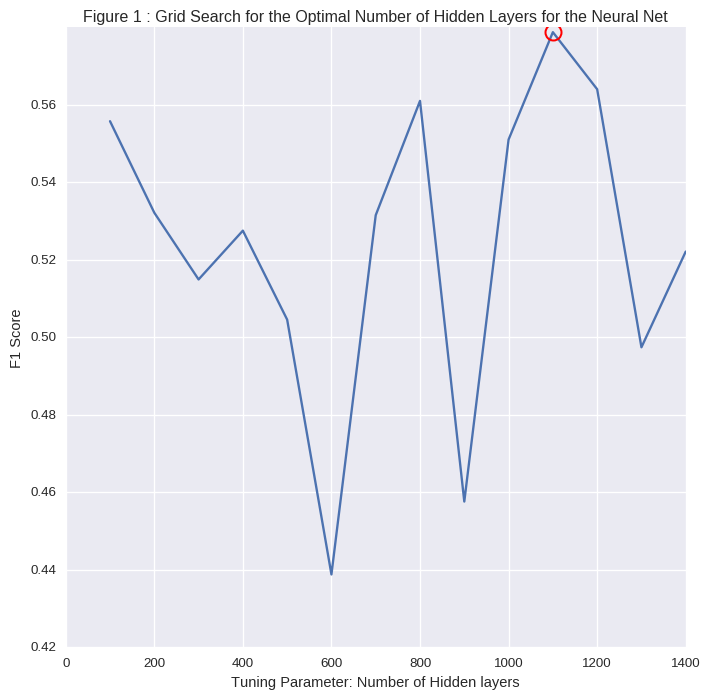

In [24]:
layers_range = [(i) for i in range(100, 1500, 100)]
param_grid = dict(hidden_layer_sizes=layers_range)

# Establish and fit the model, with a single, 1000 perceptron layer.
mlp = MLPClassifier()

grid = GridSearchCV(mlp, param_grid, cv=5, scoring='f1_micro')


with timeblock('Time Spent Running Grid Search'):
    grid.fit(X, y)

# check the results of the grid search
grid.grid_scores_
grid_mean_scores = [result[1] for result in grid.grid_scores_]

# this is a list of the average accuracies for each parameter combination
plt.figure(figsize=(800/my_dpi, 800/my_dpi), dpi=my_dpi)
#plt.ylim([0.10, 0.15])
plt.xlabel('Tuning Parameter: Number of Hidden layers')
plt.ylabel('F1 Score')
plt.plot(layers_range, grid_mean_scores)
plt.title('Figure 1 : Grid Search for the Optimal Number of Neurons for the Hidden Layer')
__ = plt.plot(grid.best_params_['hidden_layer_sizes'], grid.best_score_, 'ro', markersize=12, markeredgewidth=1.5,
         markerfacecolor='None', markeredgecolor='r')

## Discussion

Running MLP to find the optimal number of neurons for the hidden layer took roughly 4.25 hours to complete.  The resulting F1 scores are not very robust.  The optimal number of neurons is 1,100.  Interesting that the F1 score fluctuates so much between 400 neurons and 1000. Perhaps this is due to overfitting the model.  Rather surprised that the target variable did not need to be altered to a binary variable.   